In [1]:
from pprint import pprint

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from helpers import load_best_result, save_search_result
from loaders import load_mnist
from plotters import plot_learning_curve, plot_validation_curve

## Load and Preprocess Data

In [2]:
df = load_mnist(preprocess=True)

1    6958
0    6824
Name: target, dtype: int64


/home/jovyan/loaders.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  filtered_df['target'] = le.fit_transform(filtered_df['target'])


### Split data into training and testing

In [3]:
X = df[[c for c in df.columns if c != 'target']]
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=1)

### Scale Data

In [4]:
# Use min max scaling because input dataset is sparse, i.e. mostly zeros
scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## KNN Model Selection

In [5]:
from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier()

In [6]:
param_grid = {
    'n_neighbors': range(1, 17),
}

In [7]:
grid_search = GridSearchCV(
    estimator=clf,
    param_grid=param_grid,
    scoring='accuracy',
    return_train_score=True,
    cv=4,
    verbose=1,
    n_jobs=-1,
)

In [8]:
grid_search.fit(X_train_scaled, y_train)

Fitting 4 folds for each of 16 candidates, totalling 64 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 18.5min
[Parallel(n_jobs=-1)]: Done  64 out of  64 | elapsed: 27.1min finished


GridSearchCV(cv=4, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_neighbors': range(1, 17)}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score=True, scoring='accuracy', verbose=1)

In [9]:
save_search_result(grid_search, 'MNIST', 'KNN')

In [40]:
res = grid_search.cv_results_
res.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_n_neighbors', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score', 'split0_train_score', 'split1_train_score', 'split2_train_score', 'split3_train_score', 'mean_train_score', 'std_train_score'])

In [11]:
type(res['split0_test_score'])

numpy.ndarray

In [12]:
res['split0_train_score'].shape

(16,)

In [41]:
train_scores = np.vstack((res['split0_train_score'], res['split1_train_score'], res['split2_train_score'], res['split3_train_score'])).T
test_scores = np.vstack((res['split0_test_score'], res['split1_test_score'], res['split2_test_score'], res['split3_test_score'])).T

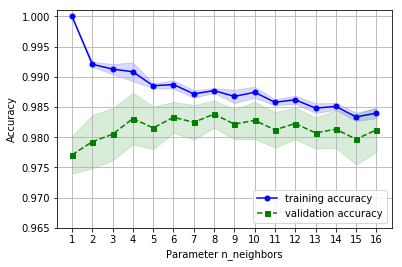

In [46]:
train_mean, train_std, test_mean, test_std = plot_validation_curve(train_scores, test_scores, 'n_neighbors', param_grid['n_neighbors'], ylim=[.965, 1.001])

/opt/conda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


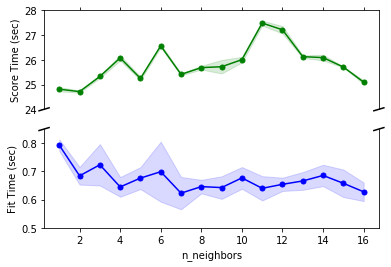

In [43]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

ax1.plot(param_grid['n_neighbors'], res['mean_score_time'],
      color='green', marker='o',
      markersize=5, label='Score time')
ax1.fill_between(param_grid['n_neighbors'],
              res['mean_score_time'] + res['std_score_time'],
              res['mean_score_time'] - res['std_score_time'],
              alpha=0.15, color='green')
ax1.set_ylabel('Score Time (sec)')
ax1.set_ylim([24, 28])

ax2.plot(param_grid['n_neighbors'], res['mean_fit_time'],
      color='blue', marker='o',
      markersize=5, label='fit time')
ax2.fill_between(param_grid['n_neighbors'],
              res['mean_fit_time'] + res['std_fit_time'],
              res['mean_fit_time'] - res['std_fit_time'],
              alpha=0.15, color='blue')
ax2.set_ylabel('Fit Time (sec)')
ax2.set_ylim(.5, .85)

ax1.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax1.xaxis.tick_top()
ax1.tick_params(labeltop='off')  # don't put tick labels at the top
ax2.xaxis.tick_bottom()

d = .015  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

plt.xlabel('n_neighbors')
plt.show()

## kNN Learning Curve Analysis

In [47]:
# Find best estimator
clf = grid_search.best_estimator_
clf.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': 1,
 'n_neighbors': 8,
 'p': 2,
 'weights': 'uniform'}

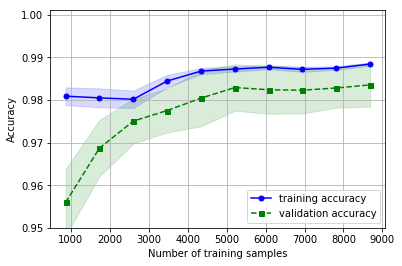

In [50]:
train_mean, train_std, test_mean, test_std = plot_learning_curve(clf, X_train_scaled, y_train, ylim=[0.95, 1.001], n_jobs=-1)